<a href="https://colab.research.google.com/github/Shreeja7Sheth/Bayesian-Analysis/blob/main/Bayesian_Linear_Regression_with_PyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bayesian Linear Regression with PyMC

**About:** The project involves simulating linear data with added noise and then fitting a Bayesian linear regression model to this data.

**Objective:** The goal is to produce posterior distributions for the model’s parameters, which allows for uncertainty quantification. This simulation and fitting process not only provides insights into the model’s behavior but also serves as a method to validate the model by comparing the fitted parameters to the known true values.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns




In [4]:
sns.set(style="darkgrid", palette="muted")


def simulate_linear_data(
    start, stop, N, beta_0, beta_1, eps_mean, eps_sigma_sq
):
    """
    Simulate a random dataset using a noisy
    linear process.

    Parameters
    ----------
    N: `int`
        Number of data points to simulate
    beta_0: `float`
        Intercept
    beta_1: `float`
        Slope of univariate predictor, X

    Returns
    -------
    df: `pd.DataFrame`
        A DataFrame containing the x and y values.
    """
    # Create a pandas DataFrame with column 'x' containing
    # N uniformly sampled values between 0.0 and 1.0
    df = pd.DataFrame(
        {"x":
            np.linspace(start, stop, num=N)
        }
    )
    # Use a linear model (y ~ beta_0 + beta_1*x + epsilon) to
    # generate a column 'y' of responses based on 'x'
    df["y"] = beta_0 + beta_1*df["x"] + np.random.RandomState(s).normal(
        eps_mean, eps_sigma_sq, N
    )
    return df




In [5]:
def plot_simulated_data(df):
    """
    Plot the simulated data with sns.lmplot()

    Parameters
    ----------
    df: `pd.DataFrame`
        A DataFrame containing the x and y values.
    """
    # Plot the data, and a frequentist linear regression fit
    # using the seaborn package
    sns.lmplot(x="x", y="y", data=df, height=10)
    plt.xlim(0.0, 1.0)
    plt.show()




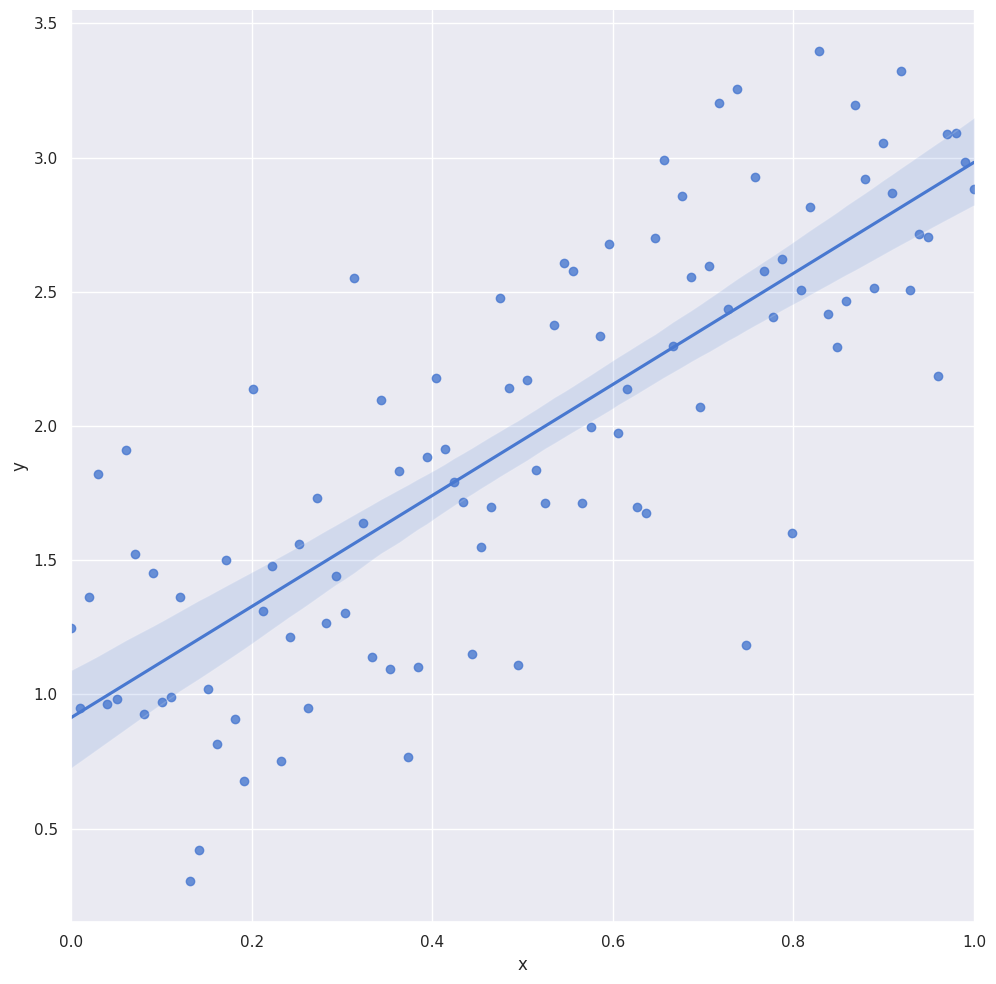

In [6]:
if __name__ == "__main__":
    # These are our "true" parameters
    beta_0 = 1.0  # Intercept
    beta_1 = 2.0  # Slope

    # Simulate 100 data points between 0 and 1, with a variance of 0.5
    start = 0
    stop = 1
    N = 100
    eps_mean = 0.0
    eps_sigma_sq = 0.5

    # Fix Random Seed
    s = 42

    # Simulate the "linear" data using the above parameters
    df = simulate_linear_data(
        start, stop, N, beta_0, beta_1, eps_mean, eps_sigma_sq
    )
    # Plot the simulated data
    plot_simulated_data(df)

Simulated 100 datapoints. The epsilon values are normally distributed with a mean of zero. The data has been plotted using the sns.lmplot method. In addition, the method uses a frequentist MLE approach to fit a linear regression line to the data.

Fitting a Bayesian linear regression to the data. This is where PyMC's glm module comes in. It uses a model specification syntax that is similar to how R specifies models. The bambi library takes a formula linear model specifier from which it creates a design matrix. bambi then adds random variables for each of the coefficients and an appopriate likelihood to the model. If bambi is not installed, you can install it with pip install bambi.

Finally, using the No-U-Turn Sampler(NUTS) to carry out the actual inference and then plot the trace of the model. We will draw 5000 samples from the posterior distribution and use the first 500 samples to tune the model then discard them as "burn in". PyMC allows you to sample multiple chains based on the number of CPUs in your system. By default it is set to the number of cores in the system, here we have explicitly set it to one.



In [7]:
 !pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.9 MB/s eta 0:00:00


In [11]:
!pip uninstall bokeh
!pip install bokeh

Found existing installation: bokeh 3.4.3
Uninstalling bokeh-3.4.3:
  Would remove:
    /usr/local/bin/bokeh
    /usr/local/lib/python3.10/dist-packages/bokeh-3.4.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/bokeh/*
    /usr/local/lib/python3.10/dist-packages/typings/IPython/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/typings/IPython/core/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/typings/IPython/core/getipython.pyi
    /usr/local/lib/python3.10/dist-packages/typings/IPython/core/history.pyi
    /usr/local/lib/python3.10/dist-packages/typings/IPython/core/interactiveshell.pyi
    /usr/local/lib/python3.10/dist-packages/typings/IPython/display.pyi
    /usr/local/lib/python3.10/dist-packages/typings/bs4.pyi
    /usr/local/lib/python3.10/dist-packages/typings/ipykernel/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/typings/ipykernel/comm/__init__.pyi
    /usr/local/lib/python3.10/dist-packages/typings/ipykernel/comm/comm.pyi
    /usr/local/

In [7]:
# NEW
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# NEW
import pymc as pm
import seaborn as sns





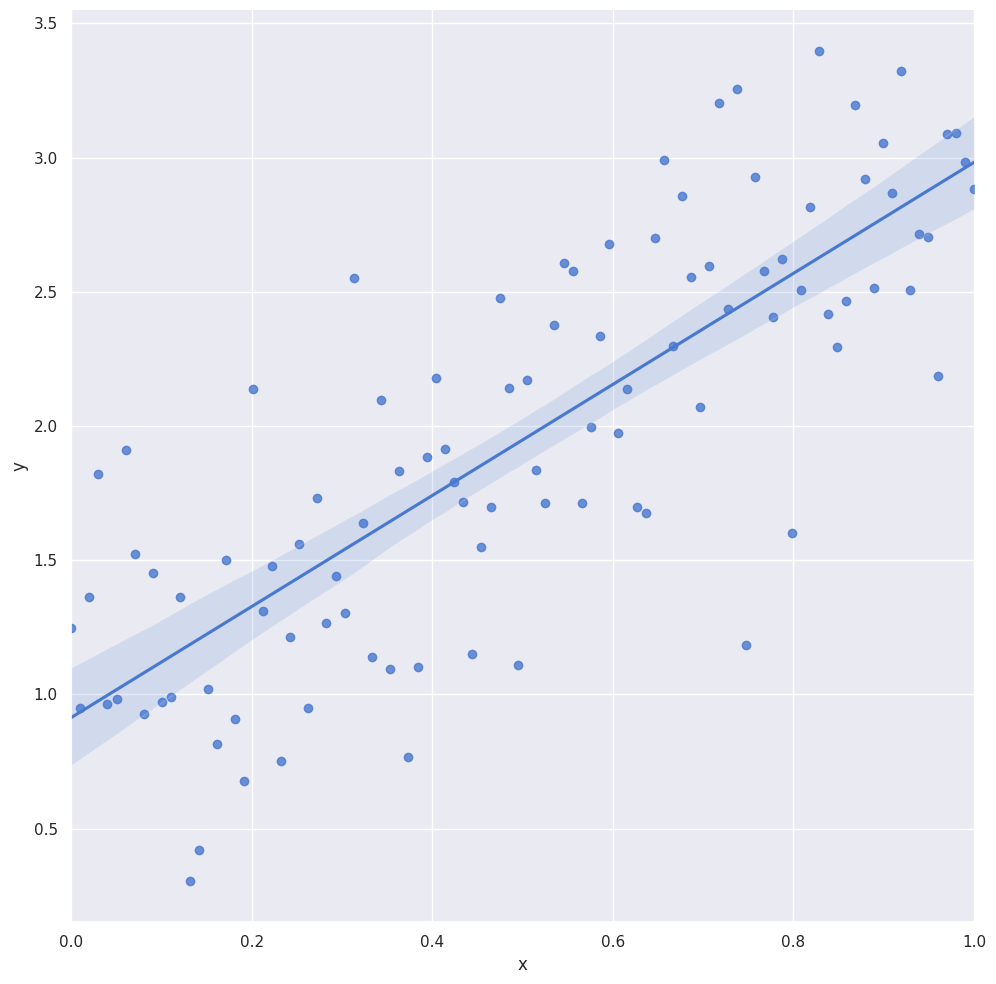

Output()

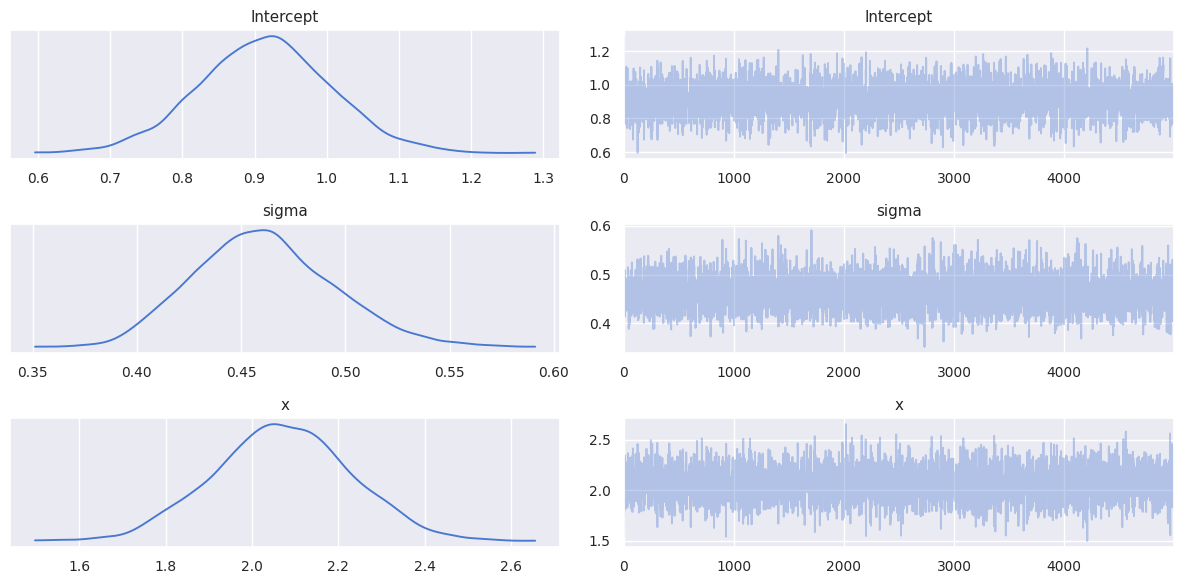

In [8]:
def glm_mcmc_inference(df, iterations=5000):
    """
    Calculates the Markov Chain Monte Carlo trace of
    a Generalised Linear Model Bayesian linear regression
    model on supplied data.

    Parameters
    ----------
    df: `pd.DataFrame`
        DataFrame containing the data
    iterations: `int`
        Number of iterations to carry out MCMC for
    """
    # Create the glm using the Bambi model syntax
    model = bmb.Model("y ~ x", df)

    # Fit the model using a NUTS (No-U-Turn Sampler)
    trace = model.fit(
        draws=5000,
        tune=500,
        discard_tuned_samples=True,
        chains=1,
        progressbar=True)
    return trace


def plot_glm_model(trace):
    """
    Plot the trace generated from fitting the model.

    Parameters
    ----------
    trace: `tracepymc.backends.base.MultiTrace`
        A MultiTrace or ArviZ InferenceData object that contains the samples.
    """
    pm.plot_trace(trace)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # These are our "true" parameters
    beta_0 = 1.0  # Intercept
    beta_1 = 2.0  # Slope

    # Simulate 100 data points between 0 and 1, with a variance of 0.5
    start = 0
    stop = 1
    N = 100
    eps_mean = 0.0
    eps_sigma_sq = 0.5

    # Fix Random Seed
    s = 42

    # Simulate the "linear" data using the above parameters
    df = simulate_linear_data(
        start, stop, N, beta_0, beta_1, eps_mean, eps_sigma_sq
    )
    # Plot the simulated data
    plot_simulated_data(df)

    # NEW
    # Fit the GLM
    trace = glm_mcmc_inference(df, iterations=5000)
    # Plot the GLM
    plot_glm_model(trace)

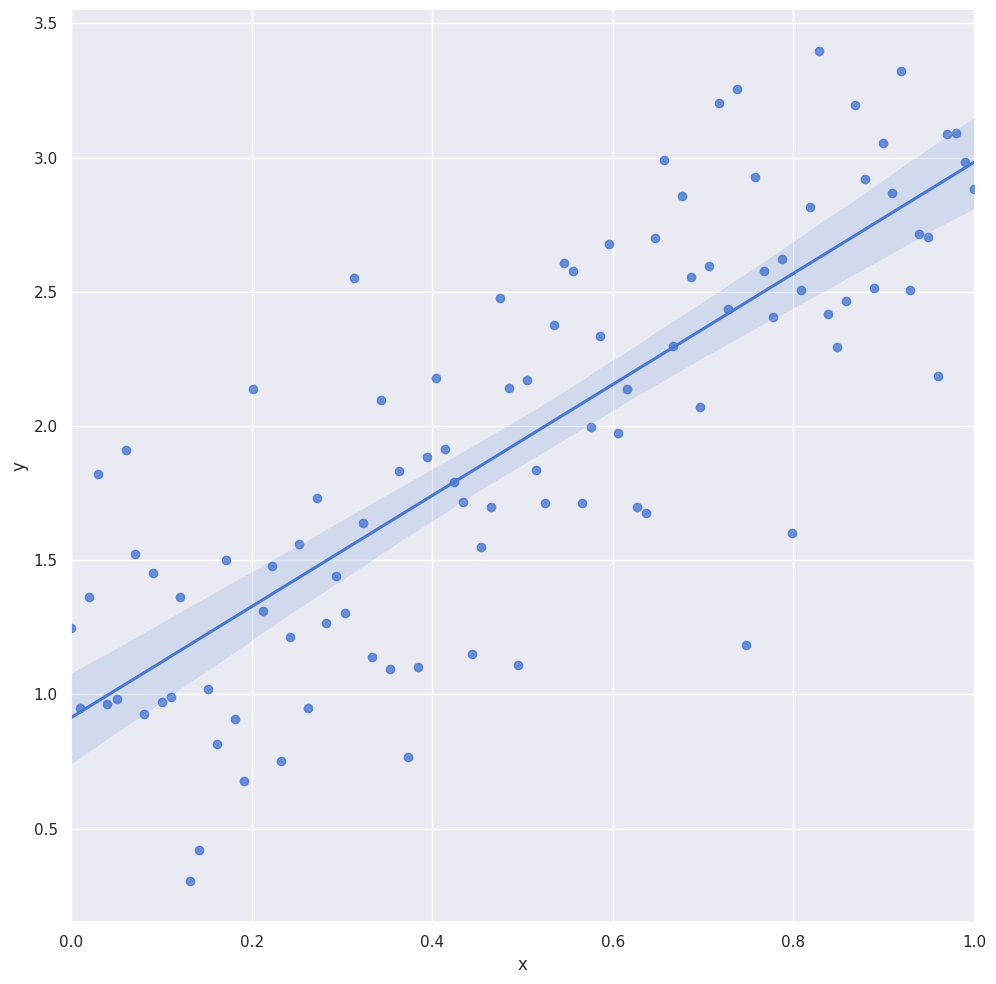

Output()

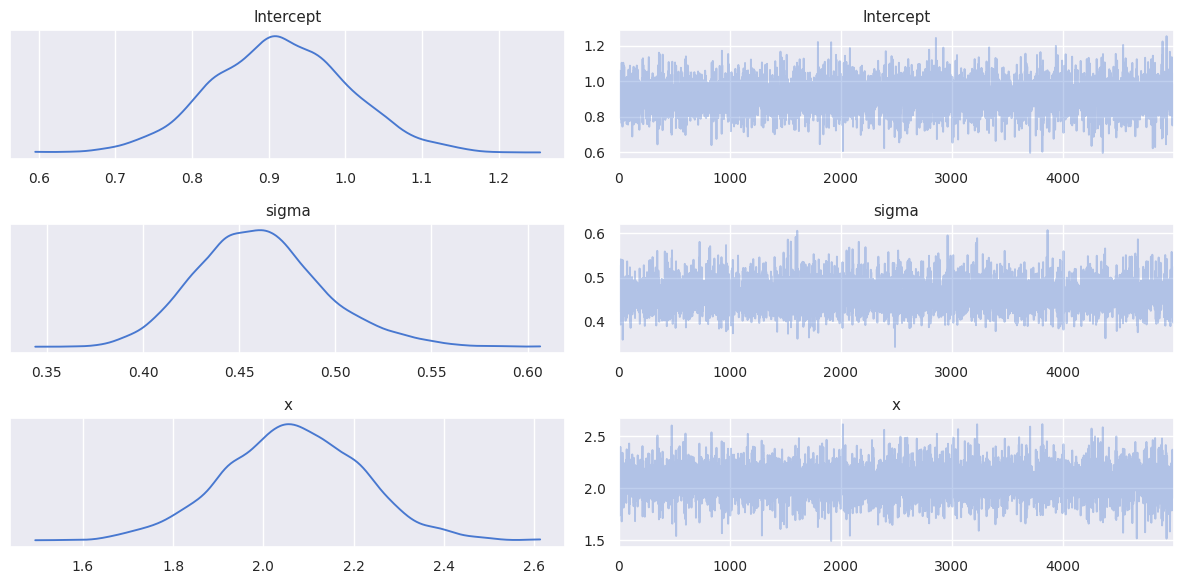

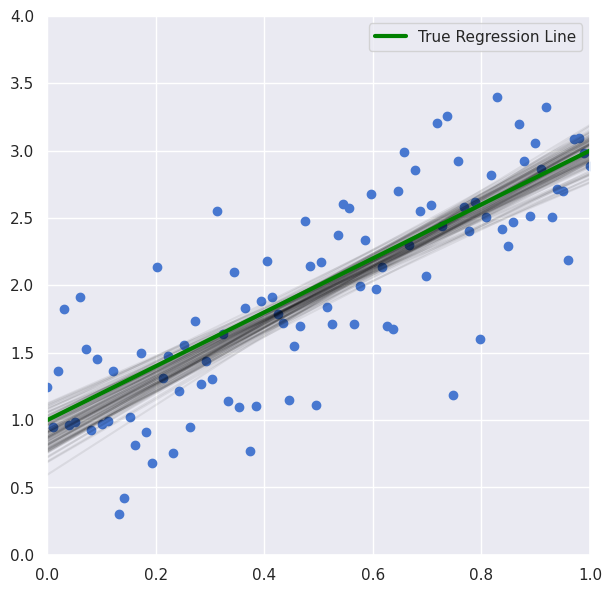

In [9]:

def plot_regression_lines(trace, df, N):
    """
    Plot the simulated data with true and estimated regression lines.

    Parameters
    ----------
    trace: `tracepymc.backends.base.MultiTrace`
        A MultiTrace or ArviZ InferenceData object that contains the samples.
    df: `pd.DataFrame`
        DataFrame containing the data
    N: `int`
        Number of data points to simulate
    """
    fig, ax = plt.subplots(figsize=(7, 7))
    # define x axis ticks
    x = np.linspace(0, 1, N)
    # plot simulated data observations
    ax.scatter(df['x'], df['y'])
    # extract slope and intercept draws from PyMC trace
    intercepts = trace.posterior.Intercept.to_numpy()[0]
    slopes = trace.posterior.x.to_numpy()[0]
    # plot 100 random samples from the slope and intercept draws
    sample_indexes = np.random.randint(len(intercepts), size=100)
    for i in sample_indexes:
        y_line = intercepts[i] + slopes[i] * x
        ax.plot(x, y_line, c='black', alpha=0.07)
    # plot true regression line
    y = beta_0 + beta_1*x
    ax.plot(x, y, label="True Regression Line", lw=3., c="green")
    ax.legend(loc=0)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 4.0)
    plt.show()


if __name__ == "__main__":
    # These are our "true" parameters
    beta_0 = 1.0  # Intercept
    beta_1 = 2.0  # Slope

    # Simulate 100 data points between 0 and 1, with a variance of 0.5
    start = 0
    stop = 1
    N = 100
    eps_mean = 0.0
    eps_sigma_sq = 0.5

    # Fix Random Seed
    s = 42

    # Simulate the "linear" data using the above parameters
    df = simulate_linear_data(
        start, stop, N, beta_0, beta_1, eps_mean, eps_sigma_sq
    )
    # Plot the simulated data
    plot_simulated_data(df)

    # Fit the GLM
    trace = glm_mcmc_inference(df, iterations=5000)
    # Plot the GLM
    plot_glm_model(trace)
    # NEW
    plot_regression_lines(trace, df, N)